### Import Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

import numpy as np
import pickle
import os, re, json, random
from collections import defaultdict

# download nltk resources
nltk.download('wordnet')
nltk.download('stopwords')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JSK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JSK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Dataset

In [2]:
# read file list
train_dataset_path = './dataset/AP_corpus_one_line_per_sentence'
tarin_dataset_list = os.listdir(train_dataset_path)

# init
text = []

# read files
for file in tarin_dataset_list:
    file_path = f'{train_dataset_path}/{file}'
    with open(file_path, 'r') as f:
        text.append(f.read())

### Text Cleaning

In [3]:
def textCleaning(sentence, is_stem=False):
    # get lowercase
    sentence = sentence.lower()

    # tokenization
    #tokenizer = TreebankWordTokenizer()
    tokenizer = RegexpTokenizer(r'\w+')
    sentence = tokenizer.tokenize(sentence)

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    sentence = [lemmatizer.lemmatize(token) for token in sentence]

    # stemming
    if is_stem:
        stemmer = PorterStemmer()
        sentence = [stemmer.stem(token) for token in sentence]

    patterns = r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"
    stop_words = set(stopwords.words('english'))

    # removing unicode characters(punctuations)
    sentence = [re.sub(patterns, '', token) for token in sentence if re.sub(patterns, '', token)]

    # removing numbers
    sentence = [re.sub(r'\d+', '', token) for token in sentence if re.sub(r'\d+', '', token)]

    # removing stopwords
    stop_words = set(stopwords.words('english'))
    sentence = [token for token in sentence if token not in stop_words]

    # removing words less than minimum word length
    processed_sentence = [token for token in sentence if len(token)>2]

    # processed_tokens = [token for token in sentence if re.sub(patterns, '', token) and not re.sub(r'\d+', '', token) and token not in stop_words and len(token) > 2]    

    return processed_sentence

def getPadded(tokens, max_len):
    seq_len = len(tokens)
    if seq_len < max_len:
        tokens = tokens + ['[PAD]']*(max_len-seq_len)
    return tokens

def preprocessing(text, save_root=None, is_save=False):
    text_clean = []
    dataset_len = len(text)

    for idx, sentence in enumerate(text):
        text_clean.append(textCleaning(sentence, is_stem=True))

        if idx%100==0:
            print(f'{idx+1:5d}/{dataset_len:5d} complete')

    # get max length
    max_len = 0
    for tokens in text_clean:
        token_length = len(tokens)

        if token_length > max_len:
            max_len = token_length

    # padding
    # padded_tokens = []

    # for idx, tokens in enumerate(text_clean):
    #     padded_tokens.append(getPadded(tokens, max_len))

    #     if idx%100==0:
    #         print(f'{idx+1:5d}/{dataset_len:5d} complete')


    # save files
    if is_save:
        with open(f'{save_root}/text_list_cleaning.pkl', 'wb') as file:
            pickle.dump(text_clean, file)

        # with open(f'{save_root}/text_list_cleaning_padded.pkl', 'wb') as file:
        #     pickle.dump(padded_tokens, file)

    return text_clean

def loadData(save_root):
    with open(f'{save_root}/text_list_cleaning.pkl', 'rb') as file:
        text_clean = pickle.load(file)

    # with open(f'{save_root}/text_list_cleaning_padded.pkl', 'rb') as file:
    #     padded_tokens = pickle.load(file)

    return text_clean

In [4]:
save_root = './dataset'

#text_clean = preprocessing(text, save_root, True)
text_clean = loadData(save_root)

### Create Vocab

In [5]:
def createVocab(word_tokens, save_root=None, is_save=False):
    # 빈도 계산을 위한 딕셔너리 초기화
    word_freq = defaultdict(int)

    # 문장을 문자열로 변환 (TfidfVectorizer는 문자열 입력을 받음)
    text_clean_str = [' '.join(sequence) for sequence in word_tokens]

    # TF-IDF Vectorizer 초기화
    vectorizer = TfidfVectorizer()

    # TF-IDF 값 계산
    tfidf_matrix = vectorizer.fit_transform(text_clean_str)

    # 각 단어의 TF-IDF 평균값 계산
    tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)

    # 단어와 그에 해당하는 TF-IDF 점수 매핑
    vocab_tfidf = {word: score for word, score in zip(vectorizer.get_feature_names_out(), tfidf_scores)}

    # TF-IDF 기준 설정
    min_tfidf = np.float64(0.00005)
    filtered_vocab = [word for word, score in vocab_tfidf.items() if score >= min_tfidf]

    # 'PAD'와 'UNK'를 0번과 1번 인덱스에 추가
    final_vocab_list = ['[PAD]', '[UNK]'] + sorted(filtered_vocab)
    final_vocab_dict = {word: idx for idx, word in enumerate(final_vocab_list)}

    if is_save:
        with open(f'{save_root}/vocab.json', 'w') as json_file:
            json.dump(final_vocab_dict, json_file)

    return final_vocab_dict

def loadVocab(save_root):
    with open(f'{save_root}/vocab.json', 'r') as json_file:
        vocab = json.load(json_file)

    return vocab

In [6]:
#vocab = createVocab(text_clean, './dataset', True)
vocab = loadVocab('./dataset')
vocab_size = len(vocab)
print(f'Vocab Length: {vocab_size}')

Vocab Length: 37690


### Integer Encoding

In [7]:
def encodeTokens(corpus_tokens, word_to_index, save_root=None, is_save=False):
    final_corpus = []
    nb_data = len(corpus_tokens)

    for idx, tokens in enumerate(corpus_tokens):
        final_corpus.append([word_to_index.get(token, word_to_index['[UNK]']) for token in tokens])
        print(f'[{idx+1:3d} / {nb_data:3d}] complete', end='\r')

    if is_save:
        with open(f'{save_root}/text_list_cleaning_encoded.pkl', 'wb') as file:
            pickle.dump(final_corpus, file)

    return final_corpus

def loadEncodedTokens(save_root):
    with open(f'{save_root}/text_list_cleaning_encoded.pkl', 'rb') as file:
        tokens = pickle.load(file)

    return tokens

#encoded_tokens = encodeTokens(text_clean, vocab, './dataset', True)
encoded_tokens = loadEncodedTokens('./dataset')

### Negative Sampling

In [8]:
import random

def save_ns_data(x_center, x_target, y, save_root, file_name):
    data = {
        'x_center': x_center,
        'x_target': x_target,
        'y': y
    }

    with open(f'{save_root}/{file_name}', 'wb') as file:
        pickle.dump(data, file)

def load_ns_data(save_root, file_name):
    with open(f'{save_root}/{file_name}', 'rb') as file:
        data = pickle.load(file)
    
    return data

def create_training_pairs(encoded_sentences, vocab_size, window_size=2, negative_samples=1):
    x_center = []
    x_target = []
    y = []

    nb_data = len(encoded_sentences)
    
    for s_idx, sentence in enumerate(encoded_sentences):
        sentence_length = len(sentence)
        for idx, center_word in enumerate(sentence):
            print(f'[ {s_idx:5d} / {nb_data:5d} ] {idx+1:5d} / {sentence_length}', end='\r')

            start = max(0, idx - window_size)
            end = min(sentence_length, idx + window_size + 1)

            # 긍정 샘플 생성
            len_pos_samples = 0
            for neighbor_idx in range(start, end):
                if neighbor_idx != idx:
                    x_center.append(center_word)
                    x_target.append(sentence[neighbor_idx])
                    y.append(1)  # 긍정 샘플 레이블

                    len_pos_samples += 1

            # 부정 샘플 생성
            existing_words = set(sentence)
            for _ in range(len_pos_samples * negative_samples):
                negative_word = random.randint(1, vocab_size - 1)
                while negative_word in existing_words:
                    negative_word = random.randint(1, vocab_size - 1)
                x_center.append(center_word)
                x_target.append(negative_word)
                y.append(0)  # 부정 샘플 레이블

        if (s_idx+1)%100 == 0:
            save_ns_data(x_center, x_target, y, './dataset', f'text_list_ns({int(s_idx/100)})')
            x_center = []
            x_target = []
            y = []

    print('\n\n') 
      
window_size = 1  # 윈도우 크기
negative_samples = 1  # 부정 샘플 개수

#create_training_pairs(encoded_tokens, vocab_size, window_size, negative_samples)

### Create Dataloader

In [9]:
class Word2VecDataset(Dataset):
    def __init__(self, x_center, x_target, y):
        self.x_center = torch.tensor(x_center)
        self.x_target = torch.tensor(x_target)
        self.y = torch.tensor(y)

        self.len = len(self.y)

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return self.x_center[idx], self.x_target[idx], self.y[idx]
    
batch_size = 128
test_size = 4096

file_list = [
    'text_list_ns(0)',
    'text_list_ns(1)',
    'text_list_ns(2)',
    'text_list_ns(3)',
    'text_list_ns(4)',
    'text_list_ns(5)',
    'text_list_ns(6)',
    'text_list_ns(7)',
    'text_list_ns(8)',
    'text_list_ns(9)',
]

data = load_ns_data(save_root, file_list[0])
x_center_test = data['x_center'][:test_size]
x_target_test = data['x_target'][:test_size]
y_test = data['y'][:test_size]

dataset_test = Word2VecDataset(x_center_test, x_target_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size, shuffle=True)

### Word2Vec

In [10]:
class Word2VecNS(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecNS, self).__init__()
        self.in_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_embeddings = nn.Embedding(vocab_size, embedding_dim)

        nn.init.xavier_uniform_(self.in_embeddings.weight)
        nn.init.xavier_uniform_(self.out_embeddings.weight)

        self.sigmoid = nn.Sigmoid()
                
    def forward(self, center_word_idx, target_word_idx):
        center_embed = self.in_embeddings(center_word_idx)
        target_embed = self.out_embeddings(target_word_idx)
        
        logits = torch.einsum('ij,ij->i', center_embed, target_embed)
        output = self.sigmoid(logits)

        return output
    
    def get_embedding(self, word_idx):
        return self.in_embeddings(word_idx)

embed_size = 128
word2vec = Word2VecNS(vocab_size, embed_size).to(device)
print(word2vec)

Word2VecNS(
  (in_embeddings): Embedding(37690, 128)
  (out_embeddings): Embedding(37690, 128)
  (sigmoid): Sigmoid()
)


### Training

In [11]:
def train(device, model, dataloader, criterion, optimizer):
    model.train()

    train_loss = 0

    nb_batch = len(dataloader)
    for idx, (x_center, x_target, y) in enumerate(dataloader):
        optimizer.zero_grad()

        x_center = x_center.to(device)
        x_target = x_target.to(device)
        y = y.to(device).float()

        output = model(x_center, x_target)

        loss = criterion(output, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        print(f'Current Batch( {idx:5d} / {nb_batch:5d} ) complete.', end='\r')

    print()
    
    train_loss = train_loss / nb_batch

    return train_loss

def evaluation(device, model, dataloader, criterion, test_size):
    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for x_center, x_target, y in dataloader:
            x_center = x_center.to(device)
            x_target = x_target.to(device)
            y = y.float()

            output = model(x_center, x_target).cpu()
            loss = criterion(output, y)
            pred = output >= torch.FloatTensor([0.5])

            val_loss += loss.item()
            val_acc += torch.sum(pred==y).item()
    
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / test_size

    return val_loss, val_acc

In [12]:
epochs = 5
lr = 1e-4

criterion = nn.BCELoss()
optimizer = optim.Adam(word2vec.parameters(), lr=lr)

log = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': []
}

dataset_test = Word2VecDataset(x_center_test, x_target_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size, shuffle=True)

nb_files = len(file_list)

for epoch in range(epochs):
    for file_idx, file in enumerate(file_list):
        data = load_ns_data(save_root, file)
        x_center_train = data['x_center']
        x_target_train = data['x_target']
        y_train = data['y']

        dataset_train = Word2VecDataset(x_center_train, x_target_train, y_train)
        dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True)

        test_loss, test_acc = evaluation(device, word2vec, dataloader_test, criterion, test_size)
        train_loss = train(device, word2vec, dataloader_train, criterion, optimizer)

        log['train_loss'].append(train_loss)
        log['test_loss'].append(test_loss)
        log['test_acc'].append(test_acc)

        print(f'[{epoch+1:3d} / {epochs:3d} - file({file_idx:3d} / {nb_files:3d})] Train({train_loss:.3f}), Test({test_loss:.3f}, {test_acc*100:.2f}%)')
    torch.save(word2vec.state_dict(), f'{save_root}/(20240929)word2vec_NS(128h_{epoch}epoch).pt')

Current Batch( 186659 / 186660 ) complete.
[  1 /   5 - file(  0 /  10)] Train(0.196), Test(0.693, 50.51%)
Current Batch( 192566 / 192567 ) complete.
[  1 /   5 - file(  1 /  10)] Train(0.183), Test(0.179, 93.36%)
Current Batch( 184389 / 184390 ) complete.
[  1 /   5 - file(  2 /  10)] Train(0.197), Test(0.239, 93.80%)
Current Batch( 180404 / 180405 ) complete.
[  1 /   5 - file(  3 /  10)] Train(0.202), Test(0.256, 93.38%)
Current Batch( 188712 / 188713 ) complete.
[  1 /   5 - file(  4 /  10)] Train(0.199), Test(0.242, 93.80%)
Current Batch( 181027 / 181028 ) complete.
[  1 /   5 - file(  5 /  10)] Train(0.201), Test(0.241, 94.14%)
Current Batch( 183668 / 183669 ) complete.
[  1 /   5 - file(  6 /  10)] Train(0.194), Test(0.242, 94.29%)
Current Batch( 192088 / 192089 ) complete.
[  1 /   5 - file(  7 /  10)] Train(0.187), Test(0.258, 94.51%)
Current Batch( 177636 / 177637 ) complete.
[  1 /   5 - file(  8 /  10)] Train(0.191), Test(0.252, 94.46%)
Current Batch( 195173 / 195174 ) comp

### Visualization

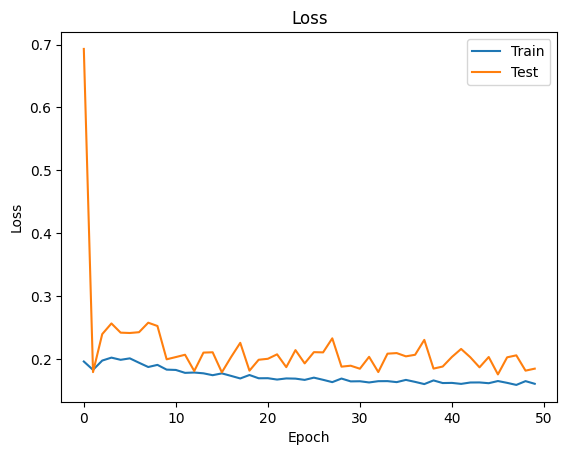

In [13]:
plt.figure()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(log['train_loss'], label='Train')
plt.plot(log['test_loss'], label='Test')

plt.legend()

plt.show()

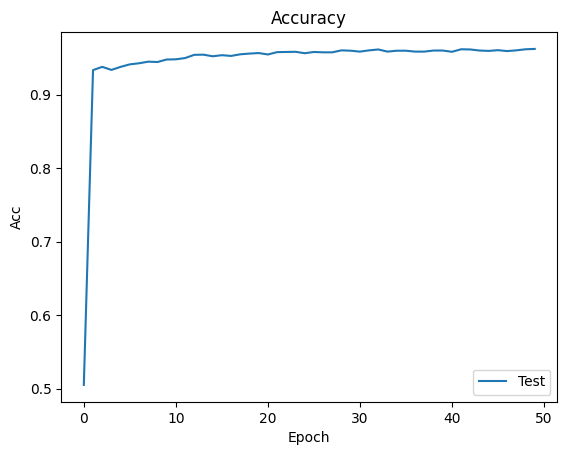

In [14]:
plt.figure()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')

plt.plot(log['test_acc'], label='Test')

plt.legend()

plt.show()